In [29]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
rivian_df = pd.read_csv('CSVs/rivian_df.csv')
rivian_hist = pd.read_csv('CSVs/historical.csv')

### Prepare DataFrame for Logistic Regression

In [ ]:
rivian_df['sign'] = [1 if ret > 0 else 0 for ret in rivian_df['Returns']]

rivian_df['overnight_sign'] = [1 if ret > 0 else 0 for ret in rivian_df['Overnight_Returns']]

# Create dummy variables

rivian_df = pd.get_dummies(rivian_df, columns = ['sent_label'], dtype = int).drop(['sent_label_neutral'], axis = 1)

# Create interaction terms 

rivian_df['neg*score'] = rivian_df['sent_label_negative']*rivian_df['sent_score']

rivian_df['pos*score'] = rivian_df['sent_label_positive']*rivian_df['sent_score']

### Checking Assumptions

In [27]:
# Checking for linearity of continuous variables using box-tidwell test

rivian_df_ln = rivian_df.copy()

rivian_df_ln['log_sentscore_int'] = (np.log(rivian_df_ln['sent_score'] + 1e-5))*rivian_df_ln['sent_score']
rivian_df_ln['log_posscore_int'] = (np.log(rivian_df_ln['pos*score'] + 1e-5))*rivian_df_ln['pos*score']
rivian_df_ln['log_negscore_int'] = (np.log(rivian_df_ln['neg*score'] + 1e-5))*rivian_df_ln['neg*score']

x = rivian_df_ln[['sent_score', 'log_sentscore_int', 'pos*score', 'log_posscore_int', 'neg*score', 'log_negscore_int']]
x = sm.add_constant(x)
y = rivian_df_ln['sign']

model = sm.Logit(y, x).fit(disp=False)
print(model.summary())

# Interaction term between positive label and sentiment score does not appear to be linear with relation to log odds of y, consider trying polynomial term in model

                           Logit Regression Results                           
Dep. Variable:                   sign   No. Observations:                  510
Model:                          Logit   Df Residuals:                      503
Method:                           MLE   Df Model:                            6
Date:                Thu, 09 Jan 2025   Pseudo R-squ.:                 0.01297
Time:                        18:50:22   Log-Likelihood:                -348.45
converged:                       True   LL-Null:                       -353.03
Covariance Type:            nonrobust   LLR p-value:                    0.1650
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.6311      5.319     -0.871      0.384     -15.057       5.794
sent_score            4.8141      5.115      0.941      0.347      -5.212      14.840
log_sentscore_int    -3.

Text(0.5, 1.0, 'RIVN Returns Jul - Dec 2024')

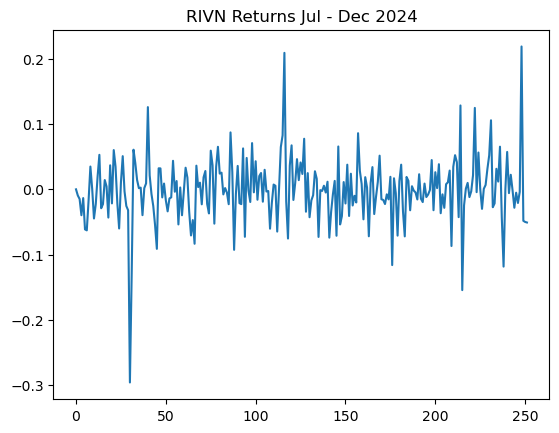

In [47]:
# Check for stationarity of returns to ensure independence of outcomes

plt.plot(rivian_hist['Returns'])
plt.title('RIVN Returns Jul - Dec 2024')

In [39]:
# Data appears stationary, confirm with augmented dickey fuller test. 

from statsmodels.tsa.stattools import adfuller

# Null Hypothesis: Time series is non-stationary

# Alt Hypothesis: Time series is stationary

result = adfuller(rivian_hist['Returns'])

print('P-Value:', result[1])

# Given low P-Value we can safely assume data is stationary and observations are independent. To account for the fact that there are multiple observations per date and therefore per return we can use clustered standard errors when specifying model. 

P-Value: 2.2097631751480537e-22


### Fitting the Model

In [41]:
y = rivian_df['sign']

x = rivian_df[['overnight_sign', 'sent_label_positive', 'sent_label_negative', 'sent_score', 'pos*score', 'neg*score']]

x = sm.add_constant(x)

model = sm.Logit(y, x).fit(cov_type = 'cluster', cov_kwds = {'groups': rivian_df['Date']})

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.612662
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   sign   No. Observations:                  510
Model:                          Logit   Df Residuals:                      503
Method:                           MLE   Df Model:                            6
Date:                Thu, 09 Jan 2025   Pseudo R-squ.:                  0.1149
Time:                        19:26:06   Log-Likelihood:                -312.46
converged:                       True   LL-Null:                       -353.03
Covariance Type:              cluster   LLR p-value:                 2.071e-15
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.0284      1.006     -3.010      0.003      -5.000      -1.057
ov

In [45]:
## Explore model with polynomials

rivian_df['pos*score^2'] = rivian_df['pos*score'] ** 2

rivian_df['pos*score^3'] = rivian_df['pos*score'] ** 3

In [46]:
y = rivian_df['sign']

x = rivian_df[['overnight_sign', 'sent_label_positive', 'sent_label_negative', 'sent_score', 'pos*score', 'pos*score^2', 'pos*score^3', 'neg*score']]

x = sm.add_constant(x)

model = sm.Logit(y, x).fit(cov_type = 'cluster', cov_kwds = {'groups': rivian_df['Date']})

print(model.summary())

## Models with polynomials did not meaninfully imrpove fit and have very large coefficients likely the result of overfitting

Optimization terminated successfully.
         Current function value: 0.609904
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   sign   No. Observations:                  510
Model:                          Logit   Df Residuals:                      501
Method:                           MLE   Df Model:                            8
Date:                Thu, 09 Jan 2025   Pseudo R-squ.:                  0.1189
Time:                        19:36:16   Log-Likelihood:                -311.05
converged:                       True   LL-Null:                       -353.03
Covariance Type:              cluster   LLR p-value:                 7.780e-15
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.0368      1.014     -2.996      0.003      -5.024      -1.050
ov